# Processing TikTok Post Data

In [1]:
# ! pip install pandas
# ! pip install matplotlib
# ! pip install gensim

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import ast
import numpy as np
from PIL import Image
import re
from wordsegment import load, segment
from gensim.models import Word2Vec
from sklearn.preprocessing import FunctionTransformer
import seaborn as sns
from sklearn.preprocessing import RobustScaler, MinMaxScaler

In [3]:
# df = pd.read_csv("../../rawData/TikTok/testPostInput.csv")
df = pd.read_csv("../../rawData/TikTok/tiktokReelData.csv")
df.head()

,id,create_time,user_name,hashtags,song,video_length,n_likes,n_shares,n_comments,n_plays,n_followers,n_total_likes,n_total_vids
0,6892428462015958273,1604768557,john.cena10,"['johncena', 'love', 'tiktok', 'fyp', 'foryoup...",الصوت الأصلي,8,1984,3,18,12800,1000000,4700000,211
1,6891790235336822018,1604619960,john.cena10,"['johncena', 'love', 'tiktok', 'halloween', 'q...",الصوت الأصلي,6,7372,9,51,52800,1000000,4700000,211
2,6891264678832475393,1604497592,john.cena10,"['johncena', 'love', 'fyp', 'foryoupage']",The Time Is Now (John Cena),5,4623,11,27,37700,1000000,4700000,211
3,6891050048403049730,1604447622,john.cena10,"['johncena', 'fyp', 'foryoupage', 'viral', 'co...",الصوت الأصلي,6,7931,6,24,51200,1000000,4700000,211
4,6890886086613126402,1604409445,john.cena10,"['johncena', 'foryoupage', 'fyp', 'viral']",الصوت الأصلي,15,3229,9,14,24700,1000000,4700000,211


#### Remove Irrelevant Data 

In [4]:
df.drop(['id', 'user_name', 'song', 'video_length', 'n_total_vids'], axis=1, inplace=True)

### Processing Time

In [5]:
df['datetime'] = pd.to_datetime(df['create_time'], unit='s')
df['year'] = df['datetime'].dt.year
df['month'] = df['datetime'].dt.month
df['day'] = df['datetime'].dt.day
df['weekday'] = df['datetime'].dt.weekday
df['hour'] = df['datetime'].dt.hour

##### Cyclical Encoding of Post's Publish Date

In [6]:
def cyclicSinEncoding(timePeriod):
    encoding = FunctionTransformer(lambda x: np.sin(x / timePeriod * 2 * np.pi))
    return encoding 

def cyclicCosEncoding(timePeriod):
    encoding = FunctionTransformer(lambda x: np.cos(x / timePeriod * 2 * np.pi))
    return encoding 

df['monthSin'] = cyclicSinEncoding(12).fit_transform(df["month"])
df['monthCos'] = cyclicCosEncoding(12).fit_transform(df["month"])

df['daySin'] = cyclicSinEncoding(31).fit_transform(df['day'])
df['dayCos'] = cyclicCosEncoding(31).fit_transform(df['day'])

df['hourSin'] = cyclicSinEncoding(24).fit_transform(df['hour'])
df['hourCos'] = cyclicCosEncoding(24).fit_transform(df['hour'])

df['weekdaySin'] = cyclicSinEncoding(7).fit_transform(df['weekday'])
df['weekdayCos'] = cyclicCosEncoding(7).fit_transform(df['weekday'])

df.drop(['weekday', 'hour', 'month', 'day', 'datetime', 'create_time'], axis=1, inplace=True)

### Processing Hashtags

#### Handle NaN Data

In [7]:
# Convert hashtags to string 

df['hashtags'] = df['hashtags'].apply(ast.literal_eval)
df['hashtags'] = df['hashtags'].apply(lambda x: x if x != [] else ["nohashtag"])

def processHashtags(hashtags):
    for i in range(len(hashtags)):
        if not hashtags[i].strip(): 
            hashtags[i] = 'nohashtag'
    return hashtags

df['hashtags'] = df['hashtags'].apply(processHashtags)
explodedDf = df['hashtags'].explode()

#### Remove Special Characters

In [8]:
def removeSpecialCharacters(hashtags):
    processedHashtag = [re.sub(r'[^a-zA-Z0-9]', '', hashtag) for hashtag in hashtags]
    processedHashtag = [hashtag.lower() for hashtag in processedHashtag]
    return processedHashtag

df['hashtags'] = df['hashtags'].apply(removeSpecialCharacters)

#### Handling Similar Hashtags

In [9]:
def processSimilarHashtags(hashtags):
    similarHashtags = ['fypforyoupage', 'fyp', 'foryou', 'foru', 'foruyou', 'fouryou', 'foryourpage', 'foryouu', 'foryoupag', '4you', 'fypforyou', 'foryoupagee', 'fouryoupage', 'fypforyourpage', 'foreyou', 'foreyoupage', 'foryour', 'foyou', 'fouyoupage' 'foryourpag', '4youpage', 'fypforyoupa', 'foryoupqge', 'fouryoupag', 'foryoupge', 'foyoupage', 'foryouoage', 'foryoyoupage', 'foreyourpage', 'foryourpages', 'fy']
    
    for i in range(len(hashtags)):
        
        if hashtags[i] in similarHashtags:
            hashtags[i] = 'foryoupage'
        
        if not hashtags[i].strip():
            hashtags[i] = 'nohashtag'
    return hashtags

df['hashtags'] = df['hashtags'].apply(processSimilarHashtags)

In [10]:
explodedDf = df['hashtags'].explode()

#### Split Words in Hashtag

In [11]:
def splitHashtagByWords(hashtags):
    wordsToIgnore = ['tiktok']
    splitHashtags = []
    for hashtag in hashtags:
        if hashtag in wordsToIgnore:
             splitHashtags.append([hashtag])
        else:    
            splitHashtags.append(segment(hashtag))
    return splitHashtags

load()
splitHashtags = df['hashtags'].apply(splitHashtagByWords)

processedHashtag = []
for hashtag in splitHashtags:
    for tag in hashtag:
        processedHashtag.append(tag)

#### Encode Hashtags using Word2Vec

In [12]:
model = Word2Vec(sentences=processedHashtag, vector_size=200, window=5, min_count=1, sg=1, workers=4)

model.save("hashtags_word2vec.model")

def encodeHashtag(hashtag):
    
    if any(word in model.wv.key_to_index for word in hashtag):
        vector = sum(model.wv[word] for word in hashtag if word in model.wv) / len(hashtag)
        return vector
    else:
        # If word, can't be found return 0
        return np.zeros(model.vector_size)

def encodeHashtagArray(hashtags):
    vectors = []
    for hashtag in hashtags:
        vector = encodeHashtag(hashtag)
        vectors.append(vector)
    
    if vectors:
        return np.mean(vectors, axis=0)
    else: 
        return np.zeros(model.vector_size)
    
df['hashtagVectors'] = df['hashtags'].apply(encodeHashtagArray)

## Accuracy of Word2Vec Model

In [13]:
vocab_size = len(model.wv.key_to_index)
print(f"Vocabulary Size: {vocab_size}")

similar_words = model.wv.most_similar('funny')
print(similar_words)

similar_words = model.wv.most_similar('food')
print(similar_words)

similar_hashtags = model.wv.most_similar('love')
print(similar_hashtags)

Vocabulary Size: 10780
[('madelaine', 0.9189252257347107), ('nba', 0.9143180251121521), ('dunks', 0.912501335144043), ('ch', 0.9119253158569336), ('vader', 0.911357045173645), ('recipes', 0.9109067320823669), ('tips', 0.9108920693397522), ('artist', 0.909850537776947), ('dobre', 0.9044932723045349), ('bollywood', 0.9044799208641052)]
[('memes', 0.9358977675437927), ('nepali', 0.9353067874908447), ('chef', 0.9322759509086609), ('arab', 0.9306944608688354), ('partner', 0.9266452193260193), ('fashion', 0.9263362884521484), ('vader', 0.9255750775337219), ('bolly', 0.9240199327468872), ('brasil', 0.9238208532333374), ('bangladesh', 0.9220990538597107)]
[('friend', 0.8460317850112915), ('ns', 0.8448972702026367), ('gura', 0.8433816432952881), ('best', 0.8427650928497314), ('goal', 0.8368711471557617), ('katrina', 0.8321726322174072), ('story', 0.8239607810974121), ('boy', 0.818328320980072), ('yusuf', 0.8135837316513062), ('telugu', 0.8055297136306763)]


## Testing a New Model

In [14]:
modelTwo = Word2Vec(sentences=processedHashtag, vector_size=150, window=3, min_count=2, sg=1, workers=4, )

vocab_size = len(modelTwo.wv.key_to_index)
print(f"Vocabulary Size: {vocab_size}")

similar_words = modelTwo.wv.most_similar('funny')
print(similar_words)

similar_words = modelTwo.wv.most_similar('food')
print(similar_words)

similar_hashtags = modelTwo.wv.most_similar('love')
print(similar_hashtags)

similar_hashtags = modelTwo.wv.most_similar('fashion')
print(similar_hashtags)

Vocabulary Size: 6314
[('recipes', 0.9126572012901306), ('youtube', 0.9112153649330139), ('kannada', 0.9110381603240967), ('strange', 0.9110276699066162), ('artist', 0.9110222458839417), ('learning', 0.9098505973815918), ('madelaine', 0.9087473154067993), ('kitchen', 0.9067452549934387), ('restart', 0.9060171246528625), ('tips', 0.9055067300796509)]
[('fashion', 0.9470153450965881), ('partner', 0.945375382900238), ('arab', 0.9436876773834229), ('chef', 0.9423551559448242), ('bolly', 0.9376357197761536), ('gallery', 0.9373347163200378), ('foodie', 0.9342400431632996), ('holiday', 0.9341127872467041), ('creator', 0.933927059173584), ('brasil', 0.9327649474143982)]
[('friend', 0.8731238842010498), ('couple', 0.8344447612762451), ('ns', 0.8299891352653503), ('yusuf', 0.8253944516181946), ('boy', 0.8253873586654663), ('katrina', 0.8251647353172302), ('gura', 0.8180786371231079), ('story', 0.8178185224533081), ('best', 0.8147670030593872), ('goal', 0.8099278807640076)]
[('food', 0.9470152854

In [15]:
# modelTwo = Word2Vec(sentences=processedHashtag, vector_size=150, window=2, min_count=5, sg=1, workers=4, epochs=20)

# modelTwo = Word2Vec(sentences=processedHashtag, vector_size=150, window=4, min_count=5, sg=1, workers=4, epochs=50)

# modelTwo = Word2Vec(sentences=processedHashtag, vector_size=150, window=4, min_count=5, sg=1, workers=4, epochs=100)

modelTwo = Word2Vec(sentences=processedHashtag, vector_size=200, window=4, min_count=5, sg=1, workers=4, epochs=200)

vocab_size = len(modelTwo.wv.key_to_index)
print(f"Vocabulary Size: {vocab_size}")

similar_words = modelTwo.wv.most_similar('funny')
print('funny', similar_words)

similar_words = modelTwo.wv.most_similar('food')
print('food', similar_words)

similar_hashtags = modelTwo.wv.most_similar('love')
print('love', similar_hashtags)

similar_hashtags = modelTwo.wv.most_similar('fashion')
print('fashion', similar_hashtags)

# Increase Corpus Size:
# The vocabulary size of 3557 is relatively small. A larger corpus with more diverse and contextually rich data could help improve the quality of embeddings.

Vocabulary Size: 3557
funny [('gta', 0.7260746955871582), ('relatable', 0.6613718867301941), ('wholesome', 0.6529170870780945), ('anxiety', 0.6085358262062073), ('bd', 0.5907071232795715), ('wiener', 0.5863430500030518), ('islamic', 0.5591027140617371), ('joo', 0.5585810542106628), ('erry', 0.5530186891555786), ('todd', 0.5491910576820374)]
food [('photography', 0.6850838661193848), ('trial', 0.6710186004638672), ('kitchen', 0.6460532546043396), ('foodie', 0.6180819272994995), ('therapy', 0.6089951992034912), ('education', 0.605603039264679), ('bangladesh', 0.6013014912605286), ('latino', 0.6006600260734558), ('sport', 0.6005028486251831), ('psychologist', 0.5973302125930786)]
love [('gura', 0.6083391904830933), ('kaif', 0.6044028997421265), ('aislinn', 0.5793555974960327), ('ns', 0.5580804944038391), ('skaamir70', 0.55689537525177), ('aitana', 0.548579216003418), ('reels', 0.5359717607498169), ('panda', 0.535075306892395), ('thanks', 0.5349835753440857), ('friendship', 0.5326516628265

### Processing Outliers

### Data Scaling

In [16]:
def calculateStatMeasures(col):
    print(f'{col}: mean={df[col].mean()}, median={df[col].median()}, mode={df[col].mode()}, std={df[col].std()}')

def plotData(xLabel, yLabel, x, y, title):
    plt.scatter(x, y, s=3)
    plt.title(title)
    plt.xlabel(xLabel)
    plt.ylabel(yLabel)
    plt.show()

In [17]:
minMaxScaler = MinMaxScaler()

df['nLikesLog'] = np.log1p(df['n_likes'])
df['nSharesLog'] = np.log1p(df['n_shares'])
df['nFollowersLog'] = np.log1p(df['n_followers'])
df['nCommentsLog'] = np.log1p(df['n_comments'])
df['nViewsLog'] = np.log1p(df['n_plays'])
df['nAccountTotalLikesLog'] = np.log1p(df['n_total_likes'])
df['nFollowersLog'] = np.log1p(df['n_followers']) 

df[['nLikes', 'nShares', 'nFollowers', 'nComments', 'nViews', 'nAccountTotalLikes', 'nFollowers', 'postYear']] = minMaxScaler.fit_transform(df[['nLikesLog', 'nSharesLog', 'nFollowersLog', 'nCommentsLog', 'nViewsLog', 'nAccountTotalLikesLog', 'nFollowersLog', 'year']])

In [18]:
df.drop(['n_shares', 'n_likes', 'n_comments', 'n_plays', 'n_followers','n_total_likes', 'hashtags', 'year', 'nLikesLog', 'nSharesLog', 'nFollowersLog', 'nCommentsLog', 'nViewsLog', 'nAccountTotalLikesLog', 'nFollowersLog'], axis=1, inplace=True)

#### Plot Data

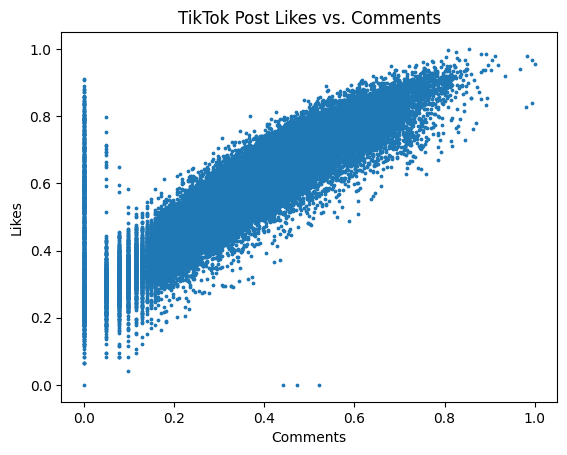

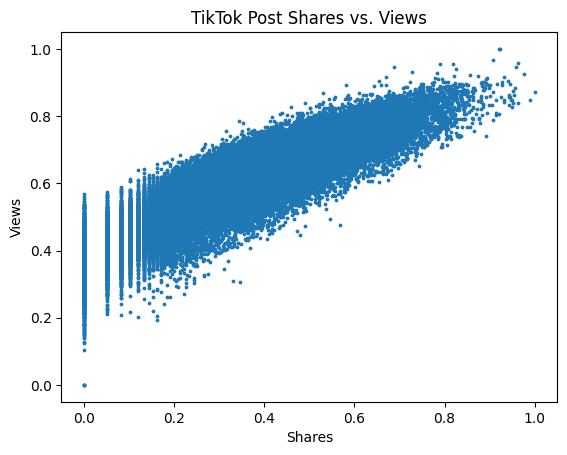

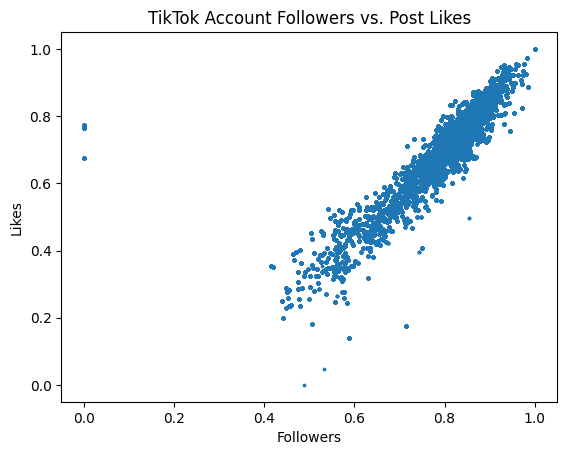

In [19]:
# plotData('Number of Comments', 'Number of Likes', df['nComments'], df['nLikes'], 'Likes and Comments of a Post')


# plotData('Number of Shares', 'Number of View', df['nShares'], df['nViews'], 'Shares and Views of a Post')

plotData('Comments', 'Likes', df['nComments'], df['nLikes'], 'TikTok Post Likes vs. Comments')
plotData('Shares', 'Views', df['nShares'], df['nViews'], 'TikTok Post Shares vs. Views')
# plotData('Number of Followers', 'Number of Likes', df['nFollowers'], df['nAccountTotalLikes'], 'Account Followers of a Post')

plotData('Followers', 'Likes', df['nFollowers'], df['nAccountTotalLikes'], 'TikTok Account Followers vs. Post Likes')

In [20]:
df.head()

,monthSin,monthCos,daySin,dayCos,hourSin,hourCos,weekdaySin,weekdayCos,hashtagVectors,nLikes,nShares,nFollowers,nComments,nViews,nAccountTotalLikes,postYear
0,-0.5,0.866025,0.988468,0.151428,-0.965926,-0.258819,-0.974928,-0.222521,"[-0.20025498, -0.14714019, 0.0720976, 0.000294...",0.448660,0.102710,0.766101,0.210350,0.471742,0.600533,1.0
1,-0.5,0.866025,0.848644,0.528964,-0.258819,0.965926,0.433884,-0.900969,"[-0.20569605, -0.15079021, 0.05271399, 0.00283...",0.526192,0.170597,0.766101,0.282275,0.542424,0.600533,1.0
2,-0.5,0.866025,0.724793,0.688967,-0.258819,-0.965926,0.974928,-0.222521,"[-0.22949898, -0.098200664, 0.08775785, -0.005...",0.498625,0.184105,0.766101,0.238051,0.525622,0.600533,1.0
3,-0.5,0.866025,0.571268,0.820763,-0.258819,0.965926,0.781831,0.623490,"[-0.18016563, -0.12841415, 0.08343793, 0.02977...",0.530510,0.144171,0.766101,0.229955,0.540889,0.600533,1.0
4,-0.5,0.866025,0.571268,0.820763,-0.258819,-0.965926,0.781831,0.623490,"[-0.22710001, -0.09222081, 0.093976095, -0.004...",0.477426,0.170597,0.766101,0.193462,0.504530,0.600533,1.0


### Store Preprocessed Data

In [21]:
df.to_csv('testTikTokPostOutput.csv', index=False)

# Model for Hashtags

In [22]:
model = Word2Vec.load("hashtags_word2vec.model")

hashtag_vector = model.wv['love']
print(hashtag_vector)



[-0.20133944 -0.18300016 -0.20658715  0.16254322  0.23184122 -0.190591
  0.02522291  0.32349446  0.2644689  -0.11827783 -0.28228238 -0.11028662
 -0.01913839 -0.10702042 -0.05856602 -0.6492461   0.27170098 -0.31164896
  0.09547513  0.17909923  0.11606138 -0.07305638  0.0667352   0.01271354
  0.15763104 -0.3659058  -0.06880591 -0.04585373 -0.08249359  0.290498
  0.02768444 -0.11103018 -0.0794041   0.040378   -0.07758345 -0.32428586
  0.00196911 -0.01231802  0.2641661  -0.36872333  0.04147306 -0.0978021
  0.11857149 -0.49646935  0.17019935  0.02110093 -0.20815551 -0.17139266
 -0.22095223 -0.0798223  -0.19508442 -0.2991289   0.11539357  0.08441242
  0.25229168  0.06656791 -0.08270934 -0.04847418 -0.2538824   0.36301512
  0.14155492  0.18538277  0.05064981 -0.0198054  -0.34974194  0.10791251
  0.11216379  0.5783422   0.02329101  0.26416242  0.05356111  0.10382765
  0.31021416  0.06608423 -0.14592044  0.0041181  -0.15118226 -0.25214985
 -0.37786937 -0.13394357 -0.04693611  0.19607347 -0.0555

## Hashtag Word Similarity

In [34]:
# Word Similarity: Measure the cosine similarity between word vectors. You can create a set of pairs of hashtags that are known to be similar and compare their cosine similarities.

from scipy.spatial.distance import cosine

# Example: Check similarity between two hashtags
similarity = 1 - cosine(model.wv['fitness'], model.wv['workout'])
print(similarity)

similarity = 1 - cosine(model.wv['funny'], model.wv['comedy'])
print(similarity)

similarity = 1 - cosine(model.wv['animal'], model.wv['dog'])
print(similarity)



0.7532103657722473
0.6745397448539734
0.7812816500663757


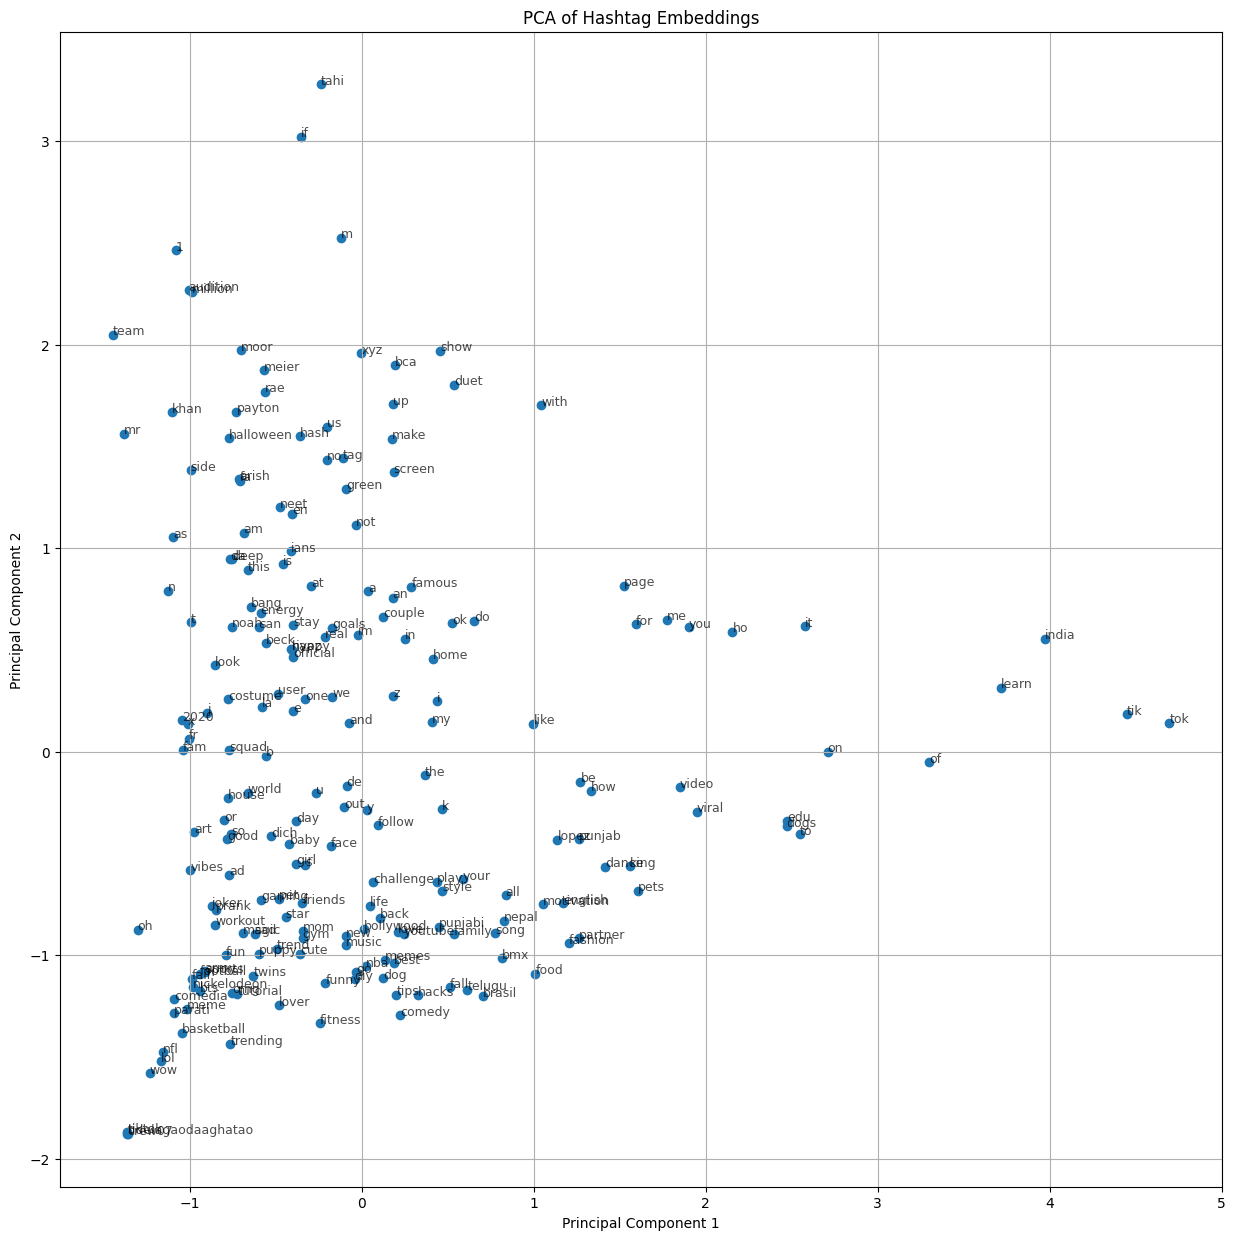

In [24]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np

# Reduce dimensions for visualization
pca = PCA(n_components=2)
vectors = [model.wv[word] for word in model.wv.index_to_key[:200]]  # Limit to top 100 hashtags for clarity
words = model.wv.index_to_key[:200]

pca_result = pca.fit_transform(vectors)

plt.figure(figsize=(15, 15))
plt.scatter(pca_result[:, 0], pca_result[:, 1], marker='o')

# Add labels
for i, word in enumerate(words):
    plt.annotate(word, xy=(pca_result[i, 0], pca_result[i, 1]), fontsize=9, alpha=0.7)

plt.title('PCA of Hashtag Embeddings')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()


In [25]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

# Silhouette Score: Evaluate the quality of clusters formed by the embeddings.

kmeans = KMeans(n_clusters=5)
kmeans.fit(vectors)
labels = kmeans.labels_
score = silhouette_score(vectors, labels)
print(score)


0.21585387


# Create Training Model

In [26]:
model = Word2Vec.load("hashtags_word2vec.model")

def get_embedding(hashtags):
    # Get embeddings for each hashtag, ignore hashtags not in the model vocabulary
    vectors = [model.wv[hashtag] for hashtag in hashtags if hashtag in model.wv]
    if vectors:
        return np.mean(vectors, axis=0)  # Aggregate by averaging
    else:
        return np.zeros(model.vector_size)  # Return zero vector if no valid hashtags

# Apply the function to the dataset
df['embedding'] = df['hashtagVectors'].apply(get_embedding)

In [27]:
X = np.vstack(df['embedding'].values)
y = df['nLikes'].values

In [28]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the regression model
regressor = RandomForestRegressor()
regressor.fit(X_train, y_train)

# Make predictions
y_pred = regressor.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")


Mean Squared Error: 0.02188235534888413
R^2 Score: -0.0001696741438539373


In [36]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns


def trainModel(model, xTrain, yTrain, modelName):
    scoring = {
    'MSE': make_scorer(mean_squared_error, greater_is_better=False),
    'R2': 'r2',
    'RMSE': make_scorer(mean_squared_error, squared=False, greater_is_better=False),
    'MAE': make_scorer(mean_absolute_error, greater_is_better=False)
    }

    # Perform cross-validation and get scores for each metric
    cvResults = cross_validate(model, xTrain, yTrain, cv=5, scoring=scoring, return_train_score=True)

    # Convert the results to a DataFrame for better readability
    resultsDf = pd.DataFrame(cvResults)

    # Since 'greater_is_better=False', the scores for MSE, RMSE, and MAE will be negative. We will negate them for correct interpretation
    resultsDf['test_MSE'] = -resultsDf['test_MSE']
    resultsDf['test_RMSE'] = -resultsDf['test_RMSE']
    resultsDf['test_MAE'] = -resultsDf['test_MAE']

    print(f'Model: {modelName}')

    print("Cross-validation results (each fold):")
    print(resultsDf[['test_MSE', 'test_R2', 'test_RMSE', 'test_MAE']])

    # Print mean and standard deviation of the metrics
    meanMetrics = resultsDf[['test_MSE', 'test_R2', 'test_RMSE', 'test_MAE']].mean()
    stdMetrics = resultsDf[['test_MSE', 'test_R2', 'test_RMSE', 'test_MAE']].std()

    print("\nMean of metrics:")
    print(meanMetrics)

    print("\nStandard Deviation of metrics:")
    print(stdMetrics)
    

    plotResults = {
    'MSE': resultsDf['test_MSE'],
    'RMSE': resultsDf['test_RMSE'],
    'MAE': resultsDf['test_MAE'],
    'R2': resultsDf['test_R2']
    }        
    
    plotResultsDf = pd.DataFrame(plotResults)   
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=plotResultsDf, palette="Set2")
    plt.title('Distribution of Cross-Validation Performance Metrics')
    plt.xlabel('Performance Metrics')
    plt.ylabel('Metric Values')
    plt.show()

In [29]:
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor

# Initialize and train Gradient Boosting Regressor
gbr = GradientBoostingRegressor()
gbr.fit(X_train, y_train)

# Make predictions
y_pred_gbr = gbr.predict(X_test)

# Evaluate the model
mse_gbr = mean_squared_error(y_test, y_pred_gbr)
r2_gbr = r2_score(y_test, y_pred_gbr)

print(f"Gradient Boosting - Mean Squared Error: {mse_gbr}")
print(f"Gradient Boosting - R^2 Score: {r2_gbr}")

# Initialize and train XGBoost Regressor
xgb = XGBRegressor()
xgb.fit(X_train, y_train)

# Make predictions
y_pred_xgb = xgb.predict(X_test)

# Evaluate the model
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f"XGBoost - Mean Squared Error: {mse_xgb}")
print(f"XGBoost - R^2 Score: {r2_xgb}")


Gradient Boosting - Mean Squared Error: 0.02188274133526131
Gradient Boosting - R^2 Score: -0.0001873162972205744
XGBoost - Mean Squared Error: 0.0218827410650654
XGBoost - R^2 Score: -0.00018730394746446777


In [30]:
def get_embedding_sum(hashtags):
    vectors = [model.wv[hashtag] for hashtag in hashtags if hashtag in model.wv]
    if vectors:
        return np.sum(vectors, axis=0)
    else:
        return np.zeros(model.vector_size)

df['embedding_sum'] = df['hashtagVectors'].apply(get_embedding_sum)

X = np.vstack(df['embedding_sum'].values)
y = df['nLikes'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor

# Initialize and train Gradient Boosting Regressor
gbr = GradientBoostingRegressor()
gbr.fit(X_train, y_train)

# Make predictions
y_pred_gbr = gbr.predict(X_test)

# Evaluate the model
mse_gbr = mean_squared_error(y_test, y_pred_gbr)
r2_gbr = r2_score(y_test, y_pred_gbr)

print(f"Gradient Boosting - Mean Squared Error: {mse_gbr}")
print(f"Gradient Boosting - R^2 Score: {r2_gbr}")

# Initialize and train XGBoost Regressor
xgb = XGBRegressor()
xgb.fit(X_train, y_train)

# Make predictions
y_pred_xgb = xgb.predict(X_test)

# Evaluate the model
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f"XGBoost - Mean Squared Error: {mse_xgb}")
print(f"XGBoost - R^2 Score: {r2_xgb}")

Gradient Boosting - Mean Squared Error: 0.02188274133526131
Gradient Boosting - R^2 Score: -0.0001873162972205744
XGBoost - Mean Squared Error: 0.0218827410650654
XGBoost - R^2 Score: -0.00018730394746446777


In [35]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}

gbr = GradientBoostingRegressor()


# Initialize the GridSearchCV object
grid_search = GridSearchCV(estimator=gbr, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# Fit the model
grid_search.fit(X_train, y_train)

# Get the best estimator
best_gbr = grid_search.best_estimator_

# Make predictions with the best estimator
y_pred_best = best_gbr.predict(X_test)

# Evaluate the best model
mse_best = mean_squared_error(y_test, y_pred_best)
r2_best = r2_score(y_test, y_pred_best)

print(f"Best Model Mean Squared Error: {mse_best}")
print(f"Best Model R^2 Score: {r2_best}")


Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=  14.5s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=  14.5s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=  14.5s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=  14.6s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=  14.8s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=200; total time=  28.0s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=200; total time=  28.1s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=200; total time=  28.5s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=200; total time=  29.7s
[CV] END ..learning_rate=0.01, max_depth=5, n_estimators=100; total time=  16.4s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=200; total time=  30.7s
[CV] END ..learning_rate=0.01, max_depth=3, n_e

# Training with K Fold

Model: Linear Regression
Cross-validation results (each fold):
   test_MSE   test_R2  test_RMSE  test_MAE
0  0.024542 -0.316961   0.156658  0.134120
1  0.023038 -0.006144   0.151782  0.123555
2  0.025450 -0.023828   0.159529  0.129450
3  0.018146 -0.016969   0.134708  0.107969
4  0.021264 -0.115848   0.145820  0.114261

Mean of metrics:
test_MSE     0.022488
test_R2     -0.095950
test_RMSE    0.149699
test_MAE     0.121871
dtype: float64

Standard Deviation of metrics:
test_MSE     0.002900
test_R2      0.131098
test_RMSE    0.009864
test_MAE     0.010741
dtype: float64


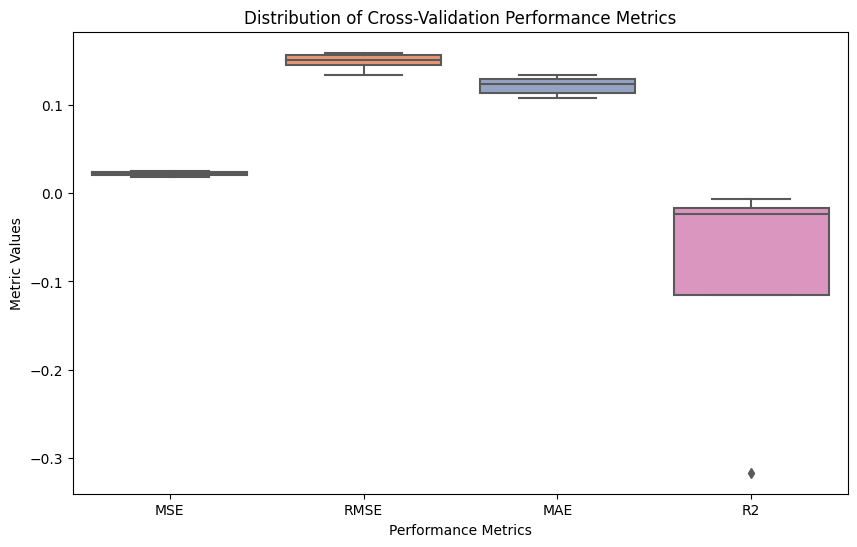

Model: Linear Regression
Cross-validation results (each fold):
   test_MSE   test_R2  test_RMSE  test_MAE
0  0.021268 -0.000330   0.145834  0.118499
1  0.021586 -0.000025   0.146923  0.119313
2  0.022642 -0.001453   0.150472  0.121703
3  0.021725 -0.000380   0.147394  0.120122
4  0.022033 -0.000012   0.148435  0.120991

Mean of metrics:
test_MSE     0.021851
test_R2     -0.000440
test_RMSE    0.147812
test_MAE     0.120125
dtype: float64

Standard Deviation of metrics:
test_MSE     0.000521
test_R2      0.000591
test_RMSE    0.001756
test_MAE     0.001279
dtype: float64


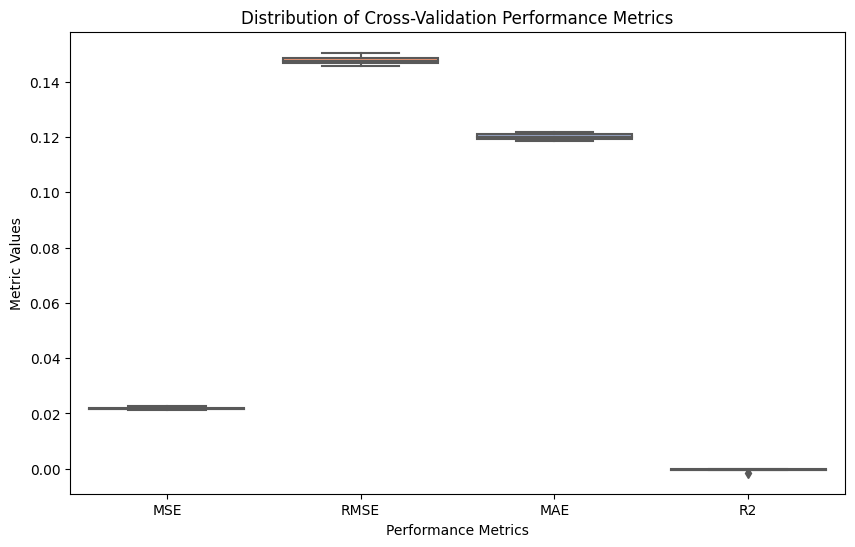

In [42]:
from sklearn.linear_model import LinearRegression

X = np.vstack(df['embedding'].values)
y = df['nLikes'].values

lr = LinearRegression()

trainModel(lr, X, y, "Linear Regression")


xTrain, xTest, yTrain, yTest = train_test_split( X, y,test_size=0.2, random_state=100)
trainModel(lr, xTrain, yTrain, "Linear Regression")



Model: XGBoost
Cross-validation results (each fold):
   test_MSE   test_R2  test_RMSE  test_MAE
0  0.024542 -0.316961   0.156658  0.134120
1  0.023038 -0.006144   0.151782  0.123555
2  0.025450 -0.023828   0.159529  0.129450
3  0.018146 -0.016969   0.134708  0.107969
4  0.021264 -0.115848   0.145820  0.114261

Mean of metrics:
test_MSE     0.022488
test_R2     -0.095950
test_RMSE    0.149699
test_MAE     0.121871
dtype: float64

Standard Deviation of metrics:
test_MSE     0.002900
test_R2      0.131098
test_RMSE    0.009864
test_MAE     0.010741
dtype: float64


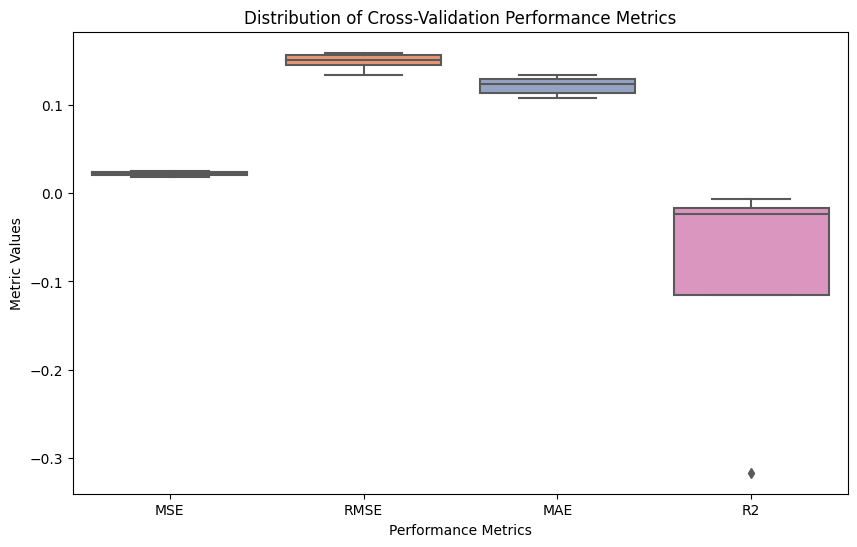

In [40]:
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor

# Initialize and train Gradient Boosting Regressor
gbr = GradientBoostingRegressor()

trainModel(gbr, X, y, "XGBoost")

Model: Random Forest Regressor
Cross-validation results (each fold):
   test_MSE   test_R2  test_RMSE  test_MAE
0  0.024541 -0.316938   0.156657  0.134118
1  0.023039 -0.006197   0.151786  0.123566
2  0.025445 -0.023641   0.159515  0.129450
3  0.018143 -0.016810   0.134697  0.107969
4  0.021261 -0.115707   0.145811  0.114256

Mean of metrics:
test_MSE     0.022486
test_R2     -0.095858
test_RMSE    0.149693
test_MAE     0.121872
dtype: float64

Standard Deviation of metrics:
test_MSE     0.002900
test_R2      0.131123
test_RMSE    0.009865
test_MAE     0.010742
dtype: float64


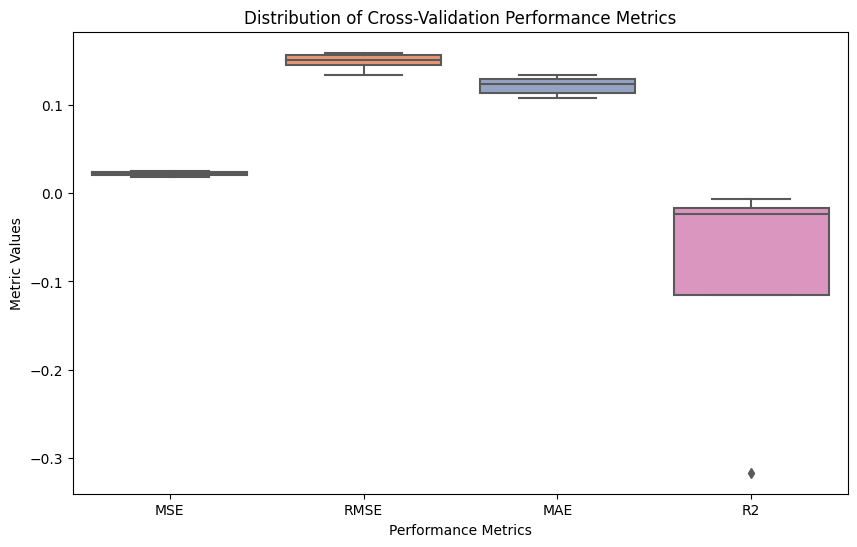

In [41]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(max_depth = 3, random_state=100)

trainModel(rf, X, y, "Random Forest Regressor")